[View in Colaboratory](https://colab.research.google.com/github/charlieLehman/mlmath/blob/master/HW05.ipynb)

# HW05 MLMATH

## 1.

## 2. 

In [0]:
from scipy.io import loadmat
from scipy.special import legendre
from scipy.integrate import quad
import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline
from tqdm import tqdm

### (a)

Import data using scipy

In [0]:
data = loadmat('hw5p2_clusterdata.mat')
T, y = data['T'], data['y']

Python version of the lpoly function

In [0]:
lpoly = lambda p,z: np.sqrt(2)*np.sqrt((2*p+2)/2)*legendre(p+1)(2*z-1)

Defined the Legendre Polynomials over range [0,1]

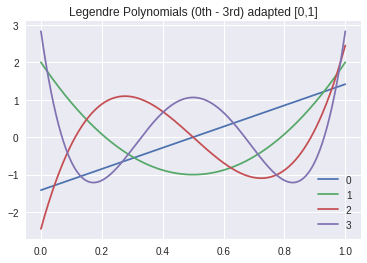

In [4]:
t = np.linspace(0,1,500)
for n in range(4):
    plt.plot(t,lpoly(n,t), label=n)
plt.legend()
plt.title('Legendre Polynomials (0th - 3rd) adapted [0,1]')
plt.show()

Setting up the least squares problem with the matrix A

Sample Error for w=1:289.583
Sample Error for LS Solution:5.907


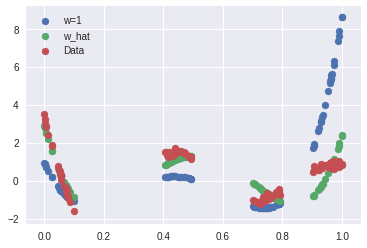

In [5]:
A = np.array([lpoly(n,T) for n in np.arange(0,4)]).squeeze().T
w_hat = np.linalg.inv(A.T@A)@A.T@y
y_hat = A@w_hat
y_0 = A@np.ones(4)
sample_error = lambda y, y_hat:  np.sqrt(((y-y_hat)**2).sum())
print_error = lambda name, y, y_hat:  print('Sample Error for {}:{:.3f}'
                                      .format(name,sample_error(y,y_hat) ))
print_error('w=1', y, y_0)
print_error('LS Solution', y, y_hat)
plt.scatter(T, y_0, label='w=1')
plt.scatter(T, y_hat, label='w_hat')
plt.scatter(T, y, label='Data')
plt.legend()

### (b)

$f_{true}(t) = \frac{sin(12(t+0.2))}{t+0.2}$

Squared Generalization Error: 0.819


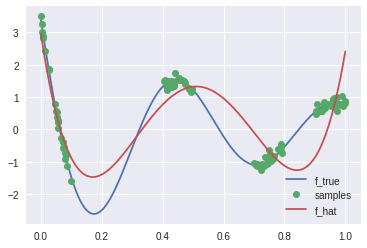

In [6]:
f_true = lambda t: np.sin(12*(t+0.2))/(t+0.2)
f_hat = lambda t: np.array([lpoly(n,t) for n in np.arange(0,4)]).squeeze().T@w_hat
gen_error = lambda f_1, f_2: np.sqrt(quad(lambda t: np.abs(f_1(t)-f_2(t))**2,0,1)[0])
print('Squared Generalization Error: {:.3f}'.format(gen_error(f_true, f_hat)))
plt.plot(t, f_true(t), label='f_true')
plt.plot(T, y, 'o', label='samples')
plt.plot(t, f_hat(t), label='f_hat')
plt.legend()


### (c)

Text(0.5,1,'Sample and Generalization Error for p = [ 5 10 15 20 25]')

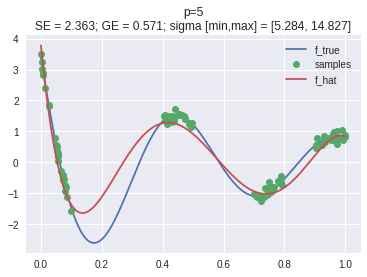

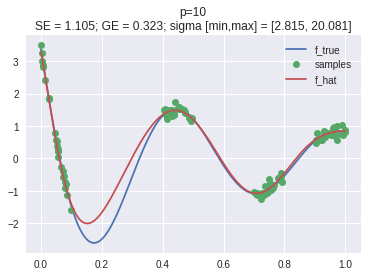

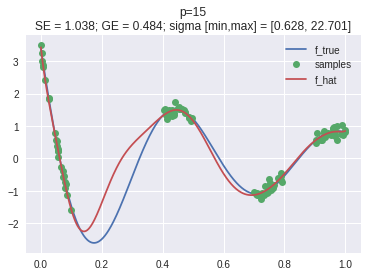

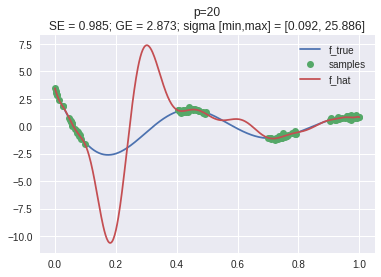

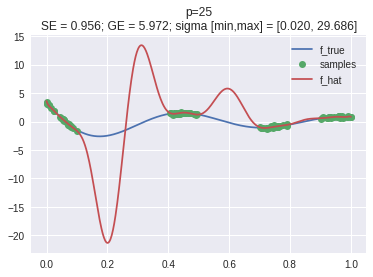

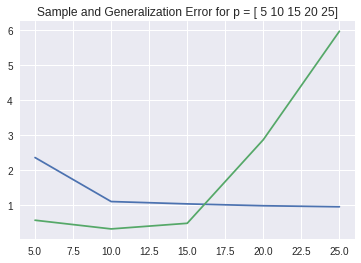

In [7]:
p_list = np.array([5,10,15,20,25])
se_l = []
ge_l = []
for i, p in enumerate(p_list):
    A = np.array([lpoly(n,T) for n in np.arange(0,p)]).squeeze().T
    u, sv, v = np.linalg.svd(A, full_matrices=False)
    simat = np.diag(1/sv)
    A_ih = v.T@simat@u.T
    w_hat = A_ih@y
    y_hat = A@w_hat
    f_hat = lambda t: np.array([lpoly(n,t) for n in np.arange(0,p)]).squeeze().T@w_hat
    se = sample_error(y_hat,y)
    ge = gen_error(f_hat,f_true)
    se_l.append(se)
    ge_l.append(ge)
    plt.figure()
    plt.plot(t, f_true(t), label='f_true')
    plt.plot(T, y, 'o', label='samples')
    plt.plot(t, f_hat(t), label='f_hat')
    plt.title('p={}\nSE = {:.3f}; GE = {:.3f}; sigma [min,max] = [{:.3f}, {:.3f}]'.format(p, se, ge, sv.min(), sv.max()))
    plt.legend()
    
plt.figure()
plt.plot(p_list, se_l, label='Sample Error')
plt.plot(p_list, ge_l, label='Generalization Error')
plt.title('Sample and Generalization Error for p = {}'.format(p_list))


The generalization error for least squares falls apart at  $p=20$ because the smallest singular value $\sigma_{20}=0.015$ causes the noise error to blow up.  Sample error however, is solving to fit the points in $y$ with least squares, which always has a minimum solution.  The concept demonstrated by the difference between generalization error and sample error is that of overfitting.  Though the solution to least squares is convex, allowing for solutions to be determined at some point additional bases actually causes the process to overfit to the samples and the generalization error out of control.  In the case of the Legendre Polynomials, additional bases adds higher-order polynomial terms that cause $\hat{f}(t)$ to have extra peaks and troughs beyond that of $f_{true}(t)$.  These additional troughs and peaks will provide additional benefit for reducing sample error, but cause the generalization error to explode.


###(d)

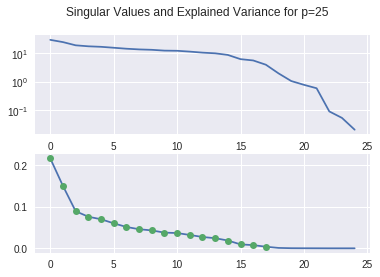

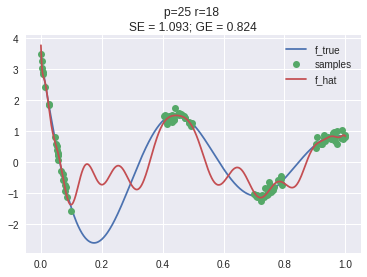

In [8]:
p = 25
A = lambda t_: np.array([lpoly(n,t_) for n in np.arange(0,p)]).squeeze().T
u, sv, v = np.linalg.svd(A(T), full_matrices=False)
fig, ax = plt.subplots(2)
explained_var = sv**2/(sv**2).sum()
idx = explained_var > 0.001
ax[0].semilogy(sv)
ax[1].plot(explained_var)
ax[1].plot(explained_var[idx], 'o')
fig.suptitle('Singular Values and Explained Variance for p=25')
simat = np.diag(1/sv[idx])
A_ih = v[idx,:].T@simat@u[:,idx].T
w_hat = A_ih@y
y_hat = A(T)@w_hat
f_hat = lambda t: np.array([lpoly(n,t) for n in np.arange(0,p)]).squeeze().T@w_hat
se = sample_error(y_hat,y)
ge = gen_error(f_hat,f_true)
se_l.append(se)
ge_l.append(ge)
plt.figure()
plt.plot(t, f_true(t), label='f_true')
plt.plot(T, y, 'o', label='samples')
plt.plot(t, f_hat(t), label='f_hat')
plt.title('p={} r={} \nSE = {:.3f}; GE = {:.3f}'.format(p,idx.sum(), se, ge))
plt.legend()


The choice of singular values was based on the explained variance of each signular value, $ev_{\sigma_r}= \sigma_r^2/\sum_n^R{\sigma_n^2}$.  More specifically:

$$
\Sigma' = \{\sigma_r : ev_{\sigma_r}>0.001, r=1\dots R\}
$$

### (e)

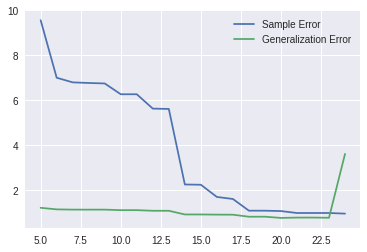

In [9]:
u, sv, v = np.linalg.svd(A(T), full_matrices=False)
R_l = np.arange(5,25,1)
se_l = []
ge_l = []
for idx in R_l:
    simat = np.diag(1/sv[:idx])
    A_ih = v[:idx,:].T@simat@u[:,:idx].T
    w_hat = A_ih@y
    y_hat = A(T)@w_hat
    f_hat = lambda t: np.array([lpoly(n,t) for n in np.arange(0,p)]).squeeze().T@w_hat
    se = sample_error(y_hat,y)
    ge = gen_error(f_hat,f_true)
    se_l.append(se)
    ge_l.append(ge)

plt.plot(R_l, se_l, label='Sample Error')
plt.plot(R_l, ge_l, label='Generalization Error')
plt.legend()


Noise error will depend on only on $\Sigma'$ as previously defined. When $5\leq R'\leq17$, the Truncation Error is evident in the large Sample Error, while the Noise Error is suppressed as evident by the low Generalization Error.  When $R'>22$ the Noise Error explodes as evident by the Generalization Error, while the Truncation Error is suppressed.

### (f)

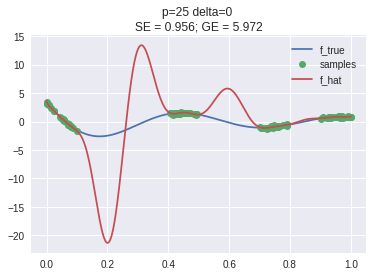

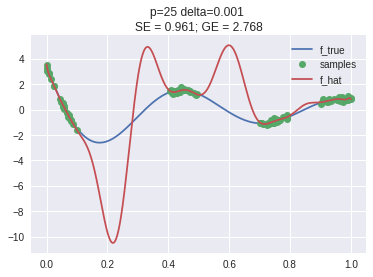

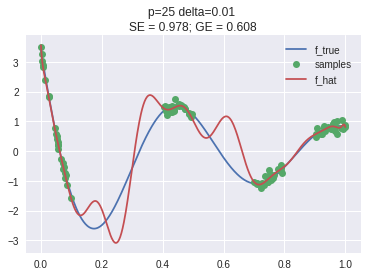

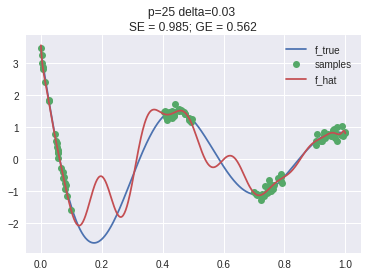

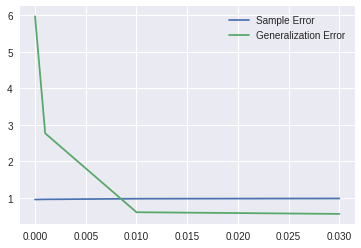

In [17]:
p = 25
d_l = [0, 1e-3, 1e-2, 3e-2]
se_l = []
ge_l = []
for delta in d_l:
    u, sv, v = np.linalg.svd(A(T), full_matrices=False)
    simat = np.diag(sv/(sv**2 + delta))
    A_ih = v.T@simat@u.T
    w_hat = A_ih@y
    y_hat = A(T)@w_hat
    f_hat = lambda t: np.array([lpoly(n,t) for n in np.arange(0,p)]).squeeze().T@w_hat
    se = sample_error(y_hat,y)
    ge = gen_error(f_hat,f_true)
    se_l.append(se)
    ge_l.append(ge)
    plt.figure()
    plt.plot(t, f_true(t), label='f_true')
    plt.plot(T, y, 'o', label='samples')
    plt.plot(t, f_hat(t), label='f_hat')
    plt.title('p={} delta={} \nSE = {:.3f}; GE = {:.3f}'.format(p, delta, se, ge))
    plt.legend()
plt.figure()
plt.plot(d_l, se_l, label='Sample Error')
plt.plot(d_l, ge_l, label='Generalization Error')
plt.legend()

As $\delta$ increases the Generalization Error also decreases because the unstable singular values are stabalized.  However, when $\delta$ is increased beyond a point the Sample and Generalization Error begin to increase.  The Sample Error is not impacted nearly as much as the Generaliztion Error.

## 3.

### (a)

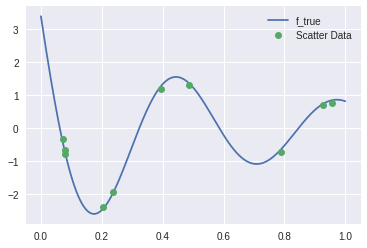

In [24]:
data = loadmat('hw5p3_scatterdata.mat')
T, y = data['T'], data['y']
plt.plot(t, f_true(t), label='f_true')
plt.plot(T,y,'o', label='Scatter Data')
plt.legend()

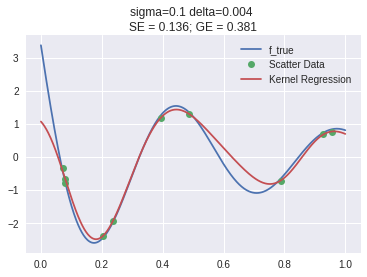

In [64]:
sigma = 1/10
delta = 0.004
k = lambda s, t, sigma:  np.exp(-np.abs(t-s)**2/(2*sigma**2))
K = np.empty((T.shape[0], T.shape[0]))

for n,t in enumerate(T):
    for m,s in enumerate(T):
        K[n,m] = k(s,t,sigma)

alpha_hat = np.linalg.inv(K+delta*np.eye(T.shape[0]))@y
f_hat = lambda t: np.array([k(t, tm, sigma) for tm in T]).T@alpha_hat
t = np.linspace(0,1,500)
se = sample_error(f_hat(T),y)
ge = gen_error(f_hat,f_true)
plt.plot(t, f_true(t), label='f_true')
plt.plot(T, y,'o', label='Scatter Data')
plt.plot(t, f_hat(t), label='Kernel Regression')
plt.title('sigma={} delta={} \nSE = {:.3f}; GE = {:.3f}'.format(sigma, delta, se, ge))
plt.legend()

This is a good choice of delta because .....

### (b)

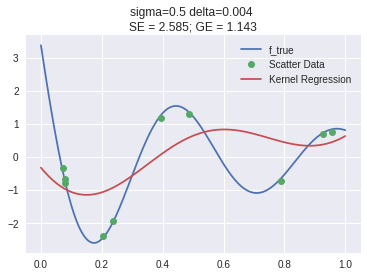

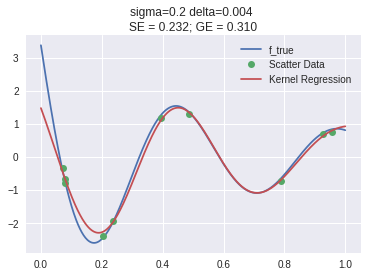

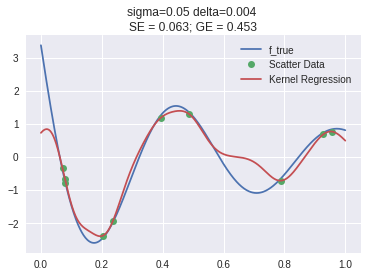

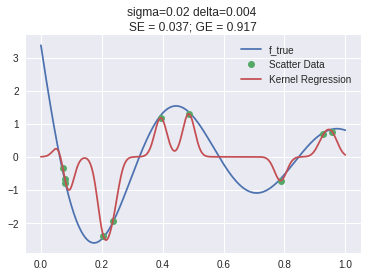

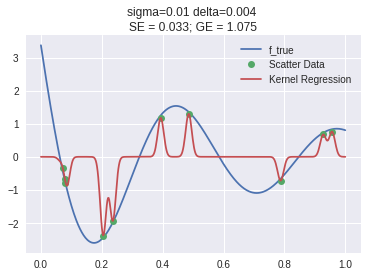

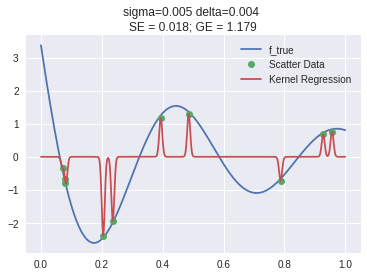

In [65]:

s_l = np.array([1/2, 1/5, 1/20, 1/50, 1/100, 1/200])
delta = 0.004
for sigma in s_l:
    K = np.empty((T.shape[0], T.shape[0]))
    for n,t in enumerate(T):
        for m,s in enumerate(T):
            K[n,m] = k(s,t,sigma)

    alpha_hat = np.linalg.inv(K+delta*np.eye(T.shape[0]))@y
    f_hat = lambda t: np.array([k(t, tm, sigma) for tm in T]).T@alpha_hat
    t = np.linspace(0,1,500)
    se = sample_error(f_hat(T),y)
    ge = gen_error(f_hat,f_true)
    plt.figure()
    plt.plot(t, f_true(t), label='f_true')
    plt.plot(T, y,'o', label='Scatter Data')
    plt.plot(t, f_hat(t), label='Kernel Regression')
    plt.title('sigma={} delta={} \nSE = {:.3f}; GE = {:.3f}'.format(sigma, delta, se, ge))
    plt.legend()

The Radial Basis Function's $\sigma$ term modifies the width of the bump function.  When $\sigma$ is small the width is small and would require there to be more samples in order to have lower Generalization Error.  

## 4.

### (a)

Text(0.5,1,'Gaussian RBF')

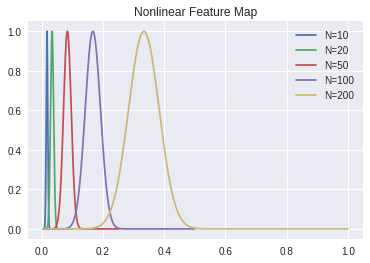

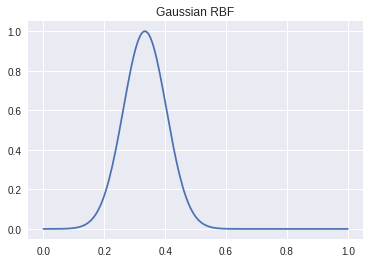

In [85]:
g = lambda t: np.exp(-200*t**2)
psi = lambda N, k, t: g(t-k/N)
t = 1/3
plt.figure()
for N in [10, 20, 50, 100, 200]:
    k = np.linspace(1,N,200)
    plt.plot(k/200, psi(N, k, t), label='N={}'.format(N))
plt.title('Nonlinear Feature Map')
plt.legend()

phi = lambda s, t: np.exp(-100*np.abs(s-t)**2)
plt.figure()
s = np.linspace(0,1,200)
plt.plot(s, phi(s, t))
plt.title('Gaussian RBF')


    